In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from datetime import datetime
from pathlib import Path
import urllib
import time
import re

sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

In [79]:
df = pd.read_parquet('../vendas.parquet.gzip')

In [80]:
vendas_dia = df.query('not cancelado & valido').groupby('dt_contabil').vl_total.sum()
vendas_dia.tail()

dt_contabil
2022-04-12     5535.0
2022-04-13     5673.0
2022-04-14     3039.0
2022-04-15    13199.0
2022-04-16    16551.5
Name: vl_total, dtype: float64

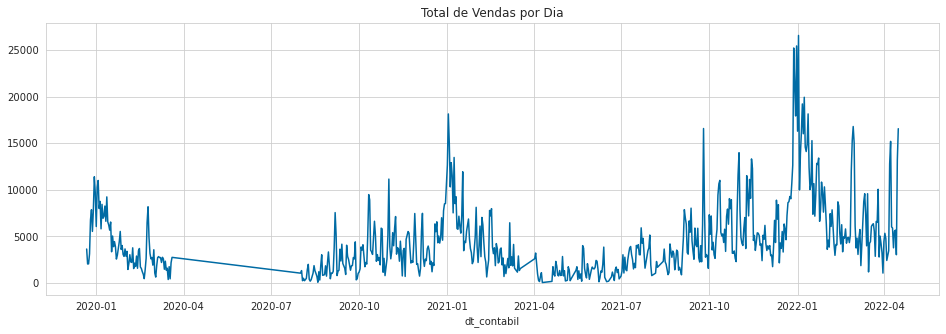

In [81]:
vendas_dia.plot(figsize=(16,5))
plt.title('Total de Vendas por Dia')
plt.show()

In [82]:

df['month'] = pd.to_datetime(df['dt_contabil']) \
    .apply(lambda x: '{year}-{month:02}'.format(year=x.year, month=x.month))
vendas_mes = df.query('not cancelado  & valido').groupby('month').vl_total.sum()
vendas_mes.tail()

month
2021-12    250344.5
2022-01    389342.4
2022-02    174181.9
2022-03    171769.5
2022-04    111093.5
Name: vl_total, dtype: float64

In [ ]:
sns.boxplot(vendas_mes['month'])
plt.show()

In [67]:
from pyspark.sql import SparkSession, SQLContext

import findspark
findspark.init()

In [3]:
spark = SparkSession.builder.appName('micasa').getOrCreate()

spark.conf.set("spark.sql.legacy.parquet.int96RebaseModeInRead", "CORRECTED")
spark.conf.set("spark.sql.legacy.parquet.int96RebaseModeInWrite", "CORRECTED")
spark.conf.set("spark.sql.legacy.parquet.datetimeRebaseModeInRead", "CORRECTED")
spark.conf.set("spark.sql.legacy.parquet.datetimeRebaseModeInWrite", "CORRECTED")

sc =  spark.sparkContext
sqlContext = SQLContext(sc)

22/04/17 11:52:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/opt/anaconda/anaconda3/envs/fastai/lib/python3.7/site-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [6]:
df = spark.read.format('parquet').load("../vendas.parquet.gzip")

In [7]:
df.createOrReplaceTempView('vendas')

22/04/17 11:53:09 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
df.count()

137945

In [9]:
df.columns

['ponto_venda',
 'modo_venda_descr',
 'nao_geral',
 'venda_id',
 'numero_venda',
 'item_id',
 'dt_contabil',
 'loja_id',
 'maquina_id',
 'modo_venda_id',
 'ponto_venda_id',
 'ticket_cod',
 'ticket_estado',
 'ticket_origem',
 'venda_origem',
 'hr_lancamento',
 'dt_hr_lancamento',
 'dt_hr_cancelamento',
 'motivo_canc_id',
 'func_id',
 'func_lancou_id',
 'func_lancou_nome',
 'func_cancelou_id',
 'func_transferiu_id',
 'func_autorizou_id',
 'material_id',
 'qtd',
 'vl_unit',
 'vl_total',
 'vl_servico_calculado',
 'vl_servico_informado',
 'situacao',
 'codigo_situacao',
 'cancelado',
 'transferido',
 'imprimiu',
 'valido',
 'motivo_canc',
 'ticket_modo_venda',
 'grupo_id',
 'grupo_descr',
 'material_cod',
 'material_cod_num',
 'material_descr',
 '__index_level_0__']

In [10]:
query = f"""
    SELECT dt_contabil, CAST(material_id AS int) AS material_id, qtd, vl_unit, vl_total
    FROM vendas
    WHERE cancelado = false
    AND valido = true
    LIMIT 3
"""

sqlContext.sql(query).show(100, False)

+-----------+-----------+---+-------+--------+
|dt_contabil|material_id|qtd|vl_unit|vl_total|
+-----------+-----------+---+-------+--------+
|2019-12-22 |43         |1.0|17.5   |17.5    |
|2019-12-22 |18         |4.0|7.5    |30.0    |
|2019-12-22 |16         |2.0|3.5    |7.0     |
+-----------+-----------+---+-------+--------+



In [11]:
query = f"""
    SELECT CAST(material_id AS int) AS material_id,
        SUM(CAST(qtd AS int)) AS qtd,
        SUM(CAST(vl_total AS DECIMAL(8,2))) AS vl_total
    FROM vendas
    WHERE cancelado = false
    GROUP BY CAST(material_id AS int)
    LIMIT 3
"""

sqlContext.sql(query).show(100, False)

+-----------+---+--------+
|material_id|qtd|vl_total|
+-----------+---+--------+
|148        |16 |270.40  |
|31         |339|1969.80 |
|137        |19 |570.00  |
+-----------+---+--------+



In [12]:
query = f"""
WITH vendas_produto AS
(
    SELECT CAST(material_id AS int) AS material_id,
        SUM(CAST(qtd AS int)) AS qtd,
        SUM(CAST(vl_total AS DECIMAL(8,2))) AS vl_total
    FROM vendas
    WHERE cancelado = false
    GROUP BY CAST(material_id AS int)
)

SELECT
    material_id,
    qtd,
    CAST(vl_total AS DECIMAL(8,2)) as vl_total,
    SUM(vl_total) OVER (ORDER BY vl_total DESC) AS vendas_acum,
    SUM(vl_total) OVER (ORDER BY vl_total DESC) / SUM(vl_total) OVER () AS porcentagem_acum,
    CASE
        WHEN SUM(vl_total) OVER (ORDER BY vl_total DESC) / SUM(vl_total) OVER () <= 0.7
            THEN 'A'
        WHEN SUM(vl_total) OVER (ORDER BY vl_total DESC) / SUM(vl_total) OVER () <= 0.9
            THEN 'B'
        ELSE 'C'
    END AS classe
FROM vendas_produto
GROUP BY
    material_id,
    qtd,
    vl_total

"""

abc_df = sqlContext.sql(query)

In [13]:
abc_df.where("classe = 'A'").count()

22/04/17 11:53:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/17 11:53:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


21

In [14]:
a_df = abc_df.selectExpr('material_id').where("classe = 'A'")

In [15]:
a_df.createOrReplaceTempView('classea')

In [16]:
query = f"""
    SELECT dt_contabil,
        CAST(material_id AS int) AS material_id,
        SUM(CAST(qtd AS int)) AS qtd,
        SUM(CAST(vl_total AS DECIMAL(8,2))) AS vl_total
    FROM vendas
    WHERE cancelado = false
    AND valido = true
    GROUP BY dt_contabil, CAST(material_id AS int)

"""

vendasdt_df = sqlContext.sql(query)

In [17]:
vendasdt_df.show(5, False)

+-----------+-----------+---+--------+
|dt_contabil|material_id|qtd|vl_total|
+-----------+-----------+---+--------+
|2019-12-25 |95         |4  |40.00   |
|2019-12-30 |87         |2  |99.00   |
|2020-01-05 |38         |3  |192.00  |
|2020-01-05 |99         |2  |30.00   |
|2020-01-09 |47         |9  |117.00  |
+-----------+-----------+---+--------+
only showing top 5 rows



In [18]:
vendasdt_df.createOrReplaceTempView('vendasdt')

In [19]:
query = f"""
    SELECT dt_contabil, a.material_id, qtd, vl_total
    FROM vendasdt AS v
    RIGHT JOIN classea AS a
        ON v.material_id = a.material_id
    ORDER BY dt_contabil
"""

vendas_df = sqlContext.sql(query)

In [87]:
vendas_df.show(5, False)

22/04/17 13:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/17 13:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----------+-----------+---+--------+
|dt_contabil|material_id|qtd|vl_total|
+-----------+-----------+---+--------+
|2019-12-22 |21         |18 |171.00  |
|2019-12-22 |41         |6  |312.00  |
|2019-12-22 |14         |22 |103.40  |
|2019-12-22 |38         |4  |256.00  |
|2019-12-22 |80         |6  |270.00  |
+-----------+-----------+---+--------+
only showing top 5 rows



In [88]:
vendas_df.count()

22/04/17 13:33:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/17 13:33:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


10127

In [102]:
base_df = vendas_df.toPandas()

In [93]:
vendas_dia = base_df.groupby('dt_contabil').vl_total.sum()
vendas_dia.tail()

dt_contabil
2022-04-12    3120.00
2022-04-13    4435.00
2022-04-14    2166.00
2022-04-15    8724.00
2022-04-16    9852.00
Name: vl_total, dtype: object

In [55]:
base_df.head()

,dt_contabil,material_id,qtd,vl_total
0,2019-12-22,21,18,171.00
1,2019-12-22,41,6,312.00
2,2019-12-22,38,4,256.00
3,2019-12-22,80,6,270.00
4,2019-12-22,58,1,96.00


In [56]:
feriados = pd.read_feather('feriados_brasil.feather')

In [57]:
feriados['data'] = pd.to_datetime(feriados['data'], infer_datetime_format=True)

In [58]:
base_df['dt_contabil'] = pd.to_datetime(base_df['dt_contabil'], infer_datetime_format=True)

In [59]:
base_df['feriado'] = base_df['dt_contabil'].isin(feriados)

In [60]:
base_df.head()

,dt_contabil,material_id,qtd,vl_total,feriado
0,2019-12-22,21,18,171.00,False
1,2019-12-22,41,6,312.00,False
2,2019-12-22,38,4,256.00,False
3,2019-12-22,80,6,270.00,False
4,2019-12-22,58,1,96.00,False


In [61]:
base_df['dt_contabil'].min(), base_df['dt_contabil'].max()


(Timestamp('2019-12-22 00:00:00'), Timestamp('2022-04-16 00:00:00'))

In [62]:
# https://github.com/fastai

def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 
            'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)


In [50]:
add_datepart(base_df, 'dt_contabil')

/opt/anaconda/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app
/opt/anaconda/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  app.launch_new_instance()


In [51]:
base_df.columns

Index(['material_id', 'qtd', 'vl_total', 'feriado', 'dt_contabilYear',
       'dt_contabilMonth', 'dt_contabilWeek', 'dt_contabilDay',
       'dt_contabilDayofweek', 'dt_contabilDayofyear',
       'dt_contabilIs_month_end', 'dt_contabilIs_month_start',
       'dt_contabilIs_quarter_end', 'dt_contabilIs_quarter_start',
       'dt_contabilIs_year_end', 'dt_contabilIs_year_start',
       'dt_contabilElapsed'],
      dtype='object')

In [52]:
base_df.to_pickle('vendas.pickle')

In [53]:
teste = pd.read_pickle('vendas.pickle')
teste.head()

,material_id,qtd,vl_total,feriado,dt_contabilYear,dt_contabilMonth,dt_contabilWeek,dt_contabilDay,dt_contabilDayofweek,dt_contabilDayofyear,dt_contabilIs_month_end,dt_contabilIs_month_start,dt_contabilIs_quarter_end,dt_contabilIs_quarter_start,dt_contabilIs_year_end,dt_contabilIs_year_start,dt_contabilElapsed
0,21,18,171.00,False,2019,12,51,22,6,356,False,False,False,False,False,False,1576972800
1,41,6,312.00,False,2019,12,51,22,6,356,False,False,False,False,False,False,1576972800
2,38,4,256.00,False,2019,12,51,22,6,356,False,False,False,False,False,False,1576972800
3,80,6,270.00,False,2019,12,51,22,6,356,False,False,False,False,False,False,1576972800
4,58,1,96.00,False,2019,12,51,22,6,356,False,False,False,False,False,False,1576972800
